In [1]:
import numpy as np
import util
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["font.size"] = "16"
plt.rcParams["axes.labelsize"] = "16"

In [2]:
class MagneticMirror2D(object):

    #######################################################################
    # Begin physical parameters                                           #
    #######################################################################

    # domain size in meter
    Lx = 1e-2 # r direction
    Lz = 1e-1

    # spatial resolution in number of cells
    Nx = 256 
    Nz = 2048

    # mirror ratio
    R = 2.0
    B_max = 0.3  # T

    # use a reduced ion mass for faster simulations
    m_e = util.constants.m_e
    m_i = 400.0 * m_e

    # total simulation time in ion thermal crossing times
    crossing_times = 0.5

    def __init__(self):
        # plasma density m^{-3}
        self.n0 = 1e16

        # temperature
        self.Te = 300 # eV
        self.Ti = 1

        self.dx = self.Lx / self.Nx
        self.dz = self.Lz / self.Nz

        # calculate electron plasma frequency
        self.w_pe = util.plasma_freq(self.n0)
        self.w_ce = util.cyclotron_freq(self.m_e, self.B_max)
        self.v_te = util.thermal_velocity(self.Te, self.m_e)
        self.v_ti = util.thermal_velocity(self.Ti, self.m_i)
        # self.dt = 0.07 / w_pe
        # simulation timestep from electron CFL
        # self.dt = self.dz / (5.0 * util.thermal_velocity(self.Te, self.m_e))
        self.dt = 0.5 / self.w_ce
        
        # calculate the ion crossing time to get the total simulation time
        ion_crossing_time = self.Lz / \
            util.thermal_velocity(self.Ti, self.m_i)
        self.total_steps = int(np.ceil(
            self.crossing_times * ion_crossing_time / self.dt
        ))
        self.diag_steps = int(self.total_steps / 20.0)

        # calculate the flux from the thermal plasma reservoir
        self.flux_e = self.n0 * self.v_te / np.sqrt(2.0 * np.pi)
        
        # self.flux_i = self.flux_e * np.sqrt(util.constants.m_e / self.m_i)
        self.flux_i = self.n0 * self.v_ti
        

        # check spatial resolution
        self.debye_length = util.debye_length(self.Te, self.n0)

        print("Starting simulation with parameters:")
        print(f"    Lz = {self.Lz}m, Lx = {self.Lx}m")
        print(f"    Nz = {self.Nz}, Nx = {self.Nx}")
        print(f"    dz = {self.dz*1e6:.1f}um, dx = {self.dx*1e6:.1f}um")
        print(f"    Debye length = {self.debye_length*1e6:.1f} um")
        print(f"    Electron plasma frequency = {self.w_pe:.1e} Hz")
        print(f"    Electron cyclotron frequency = {self.w_ce:.1e} Hz")
        print(f"    T_e = {self.Te:.1f} eV, T_i = {self.Ti:.1f} eV")
        print(f"    v_te = {self.v_te:.1e} m/s, v_ti = {self.v_ti:.1e} m/s")
        print(f"    n0 = {self.n0:.1e} m^-3")
        print(f"    M/m = {self.m_i/util.constants.m_e:.0f}")
        print(f"    J_e = {self.flux_e*util.constants.e:.1f} A/m2")
        print(f"    J_i = {self.flux_i*util.constants.e:.1f} A/m2")
        print(f"    Ion crossing time: {ion_crossing_time}")
        print(f"    Ion crossing steps: {ion_crossing_time / self.dt:.0f}")
        print(f"    Total steps = {self.total_steps}")
mirror = MagneticMirror2D()


Starting simulation with parameters:
    Lz = 0.1m, Lx = 0.01m
    Nz = 2048, Nx = 256
    dz = 48.8um, dx = 39.1um
    Debye length = 1286.9 um
    Electron plasma frequency = 5.6e+09 Hz
    Electron cyclotron frequency = 5.3e+10 Hz
    T_e = 300.0 eV, T_i = 1.0 eV
    v_te = 1.0e+07 m/s, v_ti = 3.0e+04 m/s
    n0 = 1.0e+16 m^-3
    M/m = 400
    J_e = 6565.8 A/m2
    J_i = 47.5 A/m2
    Ion crossing time: 3.3722625361843643e-06
    Ion crossing steps: 355872
    Total steps = 177937


Processing diags202312132137/output.log ......done!
estimated total time: 4.908515694667431 hours


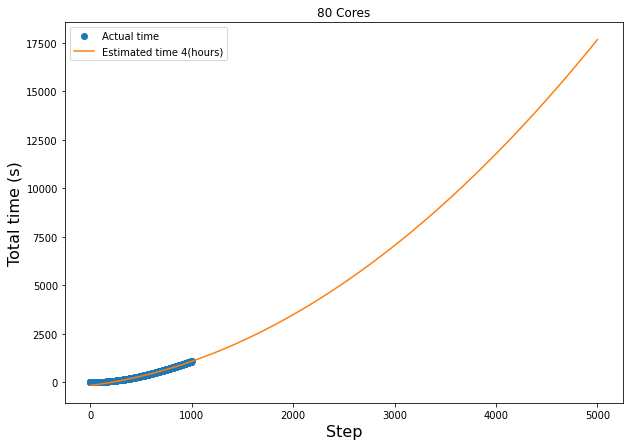

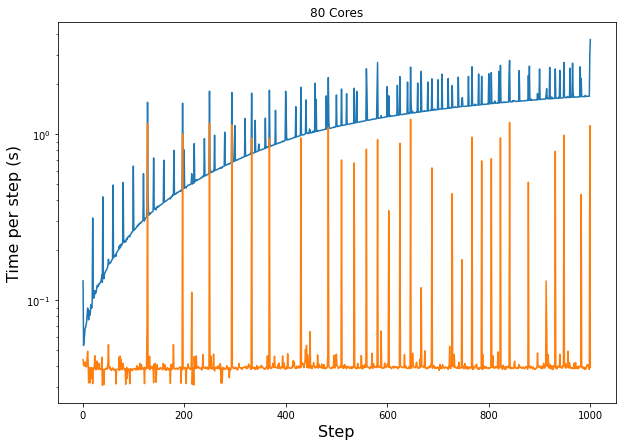

In [5]:
output_file = "diags202312132137/output.log"
specs, time_data, mlmg_data = util.extract_data(output_file)
steps = time_data[:,0]
time_per_step = time_data[:,4]
total_times = time_data[:,4].cumsum()
plt.figure(figsize=(10,7))
plt.plot(steps, total_times, "o")
plt.xlabel("Step")
plt.ylabel("Total time (s)")
plt.title(f"{specs['cores']} Cores")

p = np.polyfit(steps[steps > 500], total_times[steps > 500], 2)
# estimate_steps = np.linspace(1,mirror.total_steps)
estimate_steps = np.linspace(1, 5000)
estimate_times = np.polyval(p, estimate_steps)
plt.plot(estimate_steps, estimate_times)
plt.legend(["Actual time", f"Estimated time {int(estimate_times[-1]/3600)}(hours)"])

# print(f"Estimated to take {estimate_times[-1]/3600} hours using {specs['cores']} cores and {specs['omp_threads']} OMP threads")
plt.figure(figsize=(10,7))
plt.semilogy(steps, time_per_step)
plt.semilogy(steps, mlmg_data[:,3])
plt.xlabel("Step")
plt.ylabel("Time per step (s)")
plt.title(f"{specs['cores']} Cores")

print(f"estimated total time: {estimate_times[-1] / 3600} hours")